In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label, LabelCategory, categories_from_label_set, category_from_label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from visualizationUtils import plot_confusion_matrix
from lossesUtils import weighted_categorical_crossentropy, categorical_focal_loss
from convNetUtils import (
    cross_validation,
    evaluate_multi_output_model,
    compute_class_weights,
    images_from_dataset,
    labels_from_dataset,
    train_model,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
)
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
EPOCHS = 500 
LABELS_COORDINATES = vietnam_labels_coordinates()

In [3]:
# Only labels that contains georeferenced points.
# Label.STICK_PEPPER, now replaced by STICK_FOR_PEPPER
# Label.NATIVEVEGE, now replaced by Label.DENSE_FOREST
# Label.SEASONAL, now replaced by SEASONAL_AGRICULTURE

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_FOR_PEPPER,
    Label.PINE_TREES,
]

In [4]:
NB_PIXEL_AROUND=4

In [5]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_january_to_april/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [7]:
labels_names = [label.name for label in labels]
nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [8]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(LabelCategory)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(LabelCategory)), 
]

In [9]:
labels_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train
)

categories_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(categories_train),
    y=categories_train
)

In [10]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(1./2**16)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## Categorical cross entropy

In [11]:
model_name = "january_to_april_2018_multi_output"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': weighted_categorical_crossentropy(labels_train_weights),
    'category': weighted_categorical_crossentropy(categories_train_weights)
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 2s 3ms/step - loss: 3.7427 - label_loss: 2.4032 - category_loss: 1.3394 - label_accuracy: 0.1703 - category_accuracy: 0.3594
Epoch 2/500
432/432 [==============================] - 1s 3ms/step - loss: 3.1702 - label_loss: 2.0802 - category_loss: 1.0899 - label_accuracy: 0.2599 - category_accuracy: 0.4471
Epoch 3/500
432/432 [==============================] - 1s 3ms/step - loss: 2.9234 - label_loss: 1.9339 - category_loss: 0.9895 - label_accuracy: 0.2872 - category_accuracy: 0.5090
Epoch 4/500
432/432 [==============================] - 1s 3ms/step - loss: 2.7363 - label_loss: 1.8229 - category_loss: 0.9134 - label_accuracy: 0.3044 - category_accuracy: 0.5575
Epoch 5/500
432/432 [==============================] - 1s 3ms/step - loss: 2.6815 - label_loss: 1.7883 - category_loss: 0.8932 - label_accuracy: 0.3237 - category_accuracy: 0.5748
Epoch 6/500
432/432 [==============================] - 1s 3ms/step - loss: 2.4624 - label_loss: 1.65

432/432 [==============================] - 2s 4ms/step - loss: 1.3433 - label_loss: 0.9624 - category_loss: 0.3809 - label_accuracy: 0.5232 - category_accuracy: 0.7767
Epoch 92/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2261 - label_loss: 0.8891 - category_loss: 0.3369 - label_accuracy: 0.5470 - category_accuracy: 0.7827
Epoch 93/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3909 - label_loss: 0.9695 - category_loss: 0.4214 - label_accuracy: 0.5493 - category_accuracy: 0.7754
Epoch 94/500
432/432 [==============================] - 2s 4ms/step - loss: 1.3004 - label_loss: 0.9368 - category_loss: 0.3636 - label_accuracy: 0.5513 - category_accuracy: 0.7936
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1878 - label_loss: 0.8437 - category_loss: 0.3441 - label_accuracy: 0.5624 - category_accuracy: 0.7958
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1142 - label_loss: 0.8031 - ca

432/432 [==============================] - 2s 5ms/step - loss: 1.6363 - label_loss: 1.2261 - category_loss: 0.4102 - label_accuracy: 0.5196 - category_accuracy: 0.7707
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2299 - label_loss: 0.8831 - category_loss: 0.3468 - label_accuracy: 0.5597 - category_accuracy: 0.7938
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1552 - label_loss: 0.8363 - category_loss: 0.3189 - label_accuracy: 0.5866 - category_accuracy: 0.8103
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3333 - label_loss: 0.9215 - category_loss: 0.4118 - label_accuracy: 0.5522 - category_accuracy: 0.8079
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2878 - label_loss: 0.9280 - category_loss: 0.3598 - label_accuracy: 0.5338 - category_accuracy: 0.7858
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5112 - label_loss: 1.0537

432/432 [==============================] - 2s 5ms/step - loss: 1.1482 - label_loss: 0.8395 - category_loss: 0.3088 - label_accuracy: 0.5888 - category_accuracy: 0.8074
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0464 - label_loss: 0.7544 - category_loss: 0.2920 - label_accuracy: 0.5879 - category_accuracy: 0.8184
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1626 - label_loss: 0.8383 - category_loss: 0.3243 - label_accuracy: 0.5743 - category_accuracy: 0.8142
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3038 - label_loss: 0.8917 - category_loss: 0.4120 - label_accuracy: 0.5819 - category_accuracy: 0.8047
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0713 - label_loss: 0.7598 - category_loss: 0.3115 - label_accuracy: 0.5907 - category_accuracy: 0.8152
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4919 - label_loss: 1.0610

432/432 [==============================] - 2s 5ms/step - loss: 1.8095 - label_loss: 1.1724 - category_loss: 0.6371 - label_accuracy: 0.5087 - category_accuracy: 0.7517
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5428 - label_loss: 1.1001 - category_loss: 0.4427 - label_accuracy: 0.5266 - category_accuracy: 0.7745
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5222 - label_loss: 1.0802 - category_loss: 0.4421 - label_accuracy: 0.5158 - category_accuracy: 0.7665
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8840 - label_loss: 1.3469 - category_loss: 0.5371 - label_accuracy: 0.4940 - category_accuracy: 0.7499
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7076 - label_loss: 1.2829 - category_loss: 0.4247 - label_accuracy: 0.5357 - category_accuracy: 0.7698
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7681 - label_loss: 1.2627

432/432 [==============================] - 2s 5ms/step - loss: 1.2105 - label_loss: 0.9040 - category_loss: 0.3064 - label_accuracy: 0.5999 - category_accuracy: 0.8145
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4673 - label_loss: 1.0809 - category_loss: 0.3864 - label_accuracy: 0.5589 - category_accuracy: 0.8033
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2972 - label_loss: 0.9863 - category_loss: 0.3109 - label_accuracy: 0.5772 - category_accuracy: 0.8100
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1400 - label_loss: 0.8324 - category_loss: 0.3076 - label_accuracy: 0.5892 - category_accuracy: 0.8201
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5430 - label_loss: 1.1413 - category_loss: 0.4017 - label_accuracy: 0.5489 - category_accuracy: 0.7965
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8771 - label_loss: 1.4038

In [13]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [14]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  1.799280047416687
accuracy:  1.3452645540237427


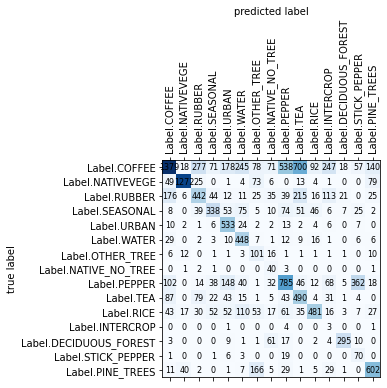

In [15]:
plot_confusion_matrix(conf_matrices[0], labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.72426471 0.92982456 0.48411829 0.58578856 0.50858779 0.45436105
 0.19688109 0.13289037 0.47924298 0.31349968 0.70424597 0.00570342
 0.83806818 0.12773723 0.66081229]
Mean precision:  0.4764017450381963

Recalls:  [0.33560477 0.83300589 0.37457627 0.45737483 0.87091503 0.81454545
 0.6516129  0.83333333 0.46977858 0.59393939 0.47908367 0.33333333
 0.73200993 0.7        0.66963293]
Mean recall:  0.6099164206063695

F-Score:  [0.45867288 0.87875648 0.42236025 0.51367781 0.64216867 0.58333333
 0.30239521 0.22922636 0.47446358 0.41038526 0.57024303 0.01121495
 0.78145695 0.21604938 0.66519337]
Mean f-score:  0.4773065019551172


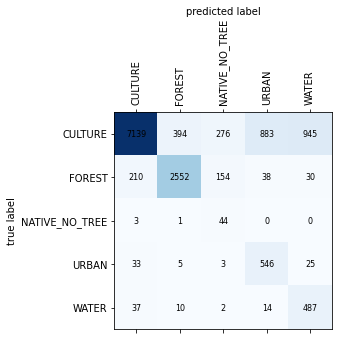

In [17]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [18]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.96187012 0.86158001 0.09185804 0.36866982 0.32750504]
Mean precision:  0.5222966056714663

Recalls:  [0.7407907  0.85522788 0.91666667 0.89215686 0.88545455]
Mean recall:  0.8580593318809244

F-Score:  [0.83697755 0.8583922  0.16698292 0.52173913 0.47815415]
Mean f-score:  0.5724491891671718


## Categorical focal loss

In [19]:
model_name = "january_to_april_2018_multi_output_focal_loss"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 3s 5ms/step - loss: 0.1892 - label_loss: 0.1586 - category_loss: 0.0306 - label_accuracy: 0.6610 - category_accuracy: 0.8928
Epoch 2/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1668 - label_loss: 0.1418 - category_loss: 0.0250 - label_accuracy: 0.6772 - category_accuracy: 0.9059
Epoch 3/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1583 - label_loss: 0.1355 - category_loss: 0.0229 - label_accuracy: 0.6935 - category_accuracy: 0.9067
Epoch 4/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1515 - label_loss: 0.1298 - category_loss: 0.0217 - label_accuracy: 0.6961 - category_accuracy: 0.9097
Epoch 5/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1468 - label_loss: 0.1257 - category_loss: 0.0210 - label_accuracy: 0.7037 - category_accuracy: 0.9138
Epoch 6/500
432/432 [==============================] - 2s 6ms/step - loss: 0.1461 - label_loss: 0.12

432/432 [==============================] - 3s 6ms/step - loss: 0.1018 - label_loss: 0.0866 - category_loss: 0.0152 - label_accuracy: 0.7660 - category_accuracy: 0.9306
Epoch 92/500
432/432 [==============================] - 3s 6ms/step - loss: 0.0969 - label_loss: 0.0825 - category_loss: 0.0144 - label_accuracy: 0.7734 - category_accuracy: 0.9339
Epoch 93/500
432/432 [==============================] - 3s 6ms/step - loss: 0.1006 - label_loss: 0.0855 - category_loss: 0.0150 - label_accuracy: 0.7701 - category_accuracy: 0.9318
Epoch 94/500
432/432 [==============================] - 3s 7ms/step - loss: 0.0983 - label_loss: 0.0836 - category_loss: 0.0148 - label_accuracy: 0.7688 - category_accuracy: 0.9336
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0993 - label_loss: 0.0845 - category_loss: 0.0149 - label_accuracy: 0.7715 - category_accuracy: 0.9351
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0951 - label_loss: 0.0809 - ca

432/432 [==============================] - 2s 5ms/step - loss: 0.0851 - label_loss: 0.0720 - category_loss: 0.0130 - label_accuracy: 0.7928 - category_accuracy: 0.9433
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0884 - label_loss: 0.0745 - category_loss: 0.0140 - label_accuracy: 0.7931 - category_accuracy: 0.9397
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0749 - category_loss: 0.0139 - label_accuracy: 0.7941 - category_accuracy: 0.9401
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0748 - category_loss: 0.0140 - label_accuracy: 0.7920 - category_accuracy: 0.9408
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0855 - label_loss: 0.0723 - category_loss: 0.0132 - label_accuracy: 0.7921 - category_accuracy: 0.9383
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0854 - label_loss: 0.0719

432/432 [==============================] - 2s 5ms/step - loss: 0.0807 - label_loss: 0.0681 - category_loss: 0.0126 - label_accuracy: 0.8042 - category_accuracy: 0.9437
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0774 - label_loss: 0.0651 - category_loss: 0.0123 - label_accuracy: 0.8095 - category_accuracy: 0.9426
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0816 - label_loss: 0.0687 - category_loss: 0.0129 - label_accuracy: 0.8001 - category_accuracy: 0.9426
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0838 - label_loss: 0.0703 - category_loss: 0.0135 - label_accuracy: 0.7965 - category_accuracy: 0.9396
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0803 - label_loss: 0.0674 - category_loss: 0.0129 - label_accuracy: 0.8023 - category_accuracy: 0.9442
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0809 - label_loss: 0.0681

432/432 [==============================] - 2s 5ms/step - loss: 0.0771 - label_loss: 0.0644 - category_loss: 0.0126 - label_accuracy: 0.8095 - category_accuracy: 0.9457
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0645 - category_loss: 0.0130 - label_accuracy: 0.8091 - category_accuracy: 0.9451
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0796 - label_loss: 0.0667 - category_loss: 0.0129 - label_accuracy: 0.8086 - category_accuracy: 0.9455
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0752 - label_loss: 0.0627 - category_loss: 0.0126 - label_accuracy: 0.8137 - category_accuracy: 0.9435
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0759 - label_loss: 0.0633 - category_loss: 0.0126 - label_accuracy: 0.8138 - category_accuracy: 0.9436
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0633

432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0627 - category_loss: 0.0123 - label_accuracy: 0.8119 - category_accuracy: 0.9449
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0589 - category_loss: 0.0112 - label_accuracy: 0.8240 - category_accuracy: 0.9489
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0630 - category_loss: 0.0120 - label_accuracy: 0.8143 - category_accuracy: 0.9467
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0727 - label_loss: 0.0607 - category_loss: 0.0120 - label_accuracy: 0.8186 - category_accuracy: 0.9463
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0587 - category_loss: 0.0114 - label_accuracy: 0.8185 - category_accuracy: 0.9488
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0746 - label_loss: 0.0620

In [21]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [22]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.16796304285526276
accuracy:  0.1413089632987976


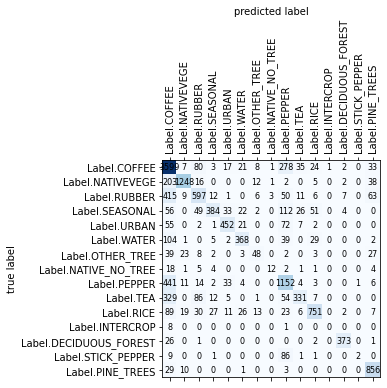

In [23]:
plot_confusion_matrix(conf_matrices[0], labels)

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.66402214 0.93905192 0.6722973  0.84768212 0.81588448 0.78969957
 0.53333333 0.70588235 0.61407249 0.78436019 0.84858757 0.
 0.95641026 0.66666667 0.82545805]
Mean precision:  0.7108938959399197

Recalls:  [0.87588221 0.8172888  0.5059322  0.51962111 0.73856209 0.66909091
 0.30967742 0.25       0.68940754 0.40121212 0.74800797 0.
 0.92555831 0.02       0.95216908]
Mean recall:  0.5614939842295434

F-Score:  [0.75537832 0.87394958 0.57736944 0.6442953  0.77530017 0.72440945
 0.39183673 0.36923077 0.64956301 0.5308741  0.7951297         nan
 0.9407314  0.03883495 0.88429752]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


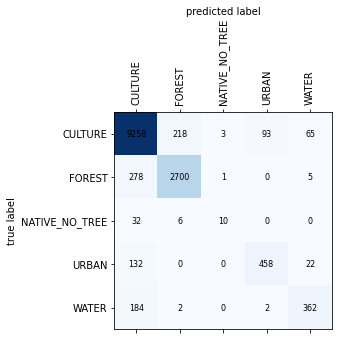

In [25]:
plot_confusion_matrix(conf_matrices[1], [category.name for category in LabelCategory])

In [26]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93666532 0.92276145 0.71428571 0.82820976 0.79735683]
Mean precision:  0.8398558148321117

Recalls:  [0.96067241 0.90482574 0.20833333 0.74836601 0.65818182]
Mean recall:  0.6960758620556643

F-Score:  [0.94851698 0.91370558 0.32258065 0.78626609 0.72111554]
Mean f-score:  0.7384369685797689


# Categorical focal loss with correct range

In [12]:
# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0001)(inputs) # the correct rescaling factor for surface reflectance dataset
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "january_to_april_2018_multi_output_focal_loss"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
432/432 [==============================] - 2s 3ms/step - loss: 0.3838 - label_loss: 0.3082 - category_loss: 0.0756 - label_accuracy: 0.4429 - category_accuracy: 0.7769
Epoch 2/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2729 - label_loss: 0.2230 - category_loss: 0.0499 - label_accuracy: 0.5497 - category_accuracy: 0.8286
Epoch 3/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2397 - label_loss: 0.1980 - category_loss: 0.0418 - label_accuracy: 0.5954 - category_accuracy: 0.8533
Epoch 4/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2190 - label_loss: 0.1813 - category_loss: 0.0377 - label_accuracy: 0.6213 - category_accuracy: 0.8702
Epoch 5/500
432/432 [==============================] - 1s 3ms/step - loss: 0.2067 - label_loss: 0.1713 - category_loss: 0.0354 - label_accuracy: 0.6343 - category_accuracy: 0.8736
Epoch 6/500
432/432 [==============================] - 1s 3ms/step - loss: 0.1924 - label_loss: 0.15

432/432 [==============================] - 2s 5ms/step - loss: 0.0853 - label_loss: 0.0711 - category_loss: 0.0142 - label_accuracy: 0.7982 - category_accuracy: 0.9383
Epoch 92/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0870 - label_loss: 0.0721 - category_loss: 0.0149 - label_accuracy: 0.7920 - category_accuracy: 0.9366
Epoch 93/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0848 - label_loss: 0.0707 - category_loss: 0.0141 - label_accuracy: 0.7983 - category_accuracy: 0.9371
Epoch 94/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0865 - label_loss: 0.0715 - category_loss: 0.0150 - label_accuracy: 0.8000 - category_accuracy: 0.9398
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0855 - label_loss: 0.0717 - category_loss: 0.0139 - label_accuracy: 0.7947 - category_accuracy: 0.9382
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0870 - label_loss: 0.0720 - ca

432/432 [==============================] - 2s 6ms/step - loss: 0.0708 - label_loss: 0.0591 - category_loss: 0.0117 - label_accuracy: 0.8177 - category_accuracy: 0.9456
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0748 - label_loss: 0.0618 - category_loss: 0.0131 - label_accuracy: 0.8129 - category_accuracy: 0.9409
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0763 - label_loss: 0.0629 - category_loss: 0.0133 - label_accuracy: 0.8082 - category_accuracy: 0.9409
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0731 - label_loss: 0.0604 - category_loss: 0.0126 - label_accuracy: 0.8166 - category_accuracy: 0.9451
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0721 - label_loss: 0.0592 - category_loss: 0.0128 - label_accuracy: 0.8186 - category_accuracy: 0.9440
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0722 - label_loss: 0.0593

432/432 [==============================] - 2s 5ms/step - loss: 0.0689 - label_loss: 0.0570 - category_loss: 0.0120 - label_accuracy: 0.8301 - category_accuracy: 0.9476
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0683 - label_loss: 0.0564 - category_loss: 0.0119 - label_accuracy: 0.8251 - category_accuracy: 0.9462
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0684 - label_loss: 0.0565 - category_loss: 0.0120 - label_accuracy: 0.8237 - category_accuracy: 0.9479
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0682 - label_loss: 0.0562 - category_loss: 0.0120 - label_accuracy: 0.8299 - category_accuracy: 0.9456
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0690 - label_loss: 0.0572 - category_loss: 0.0118 - label_accuracy: 0.8296 - category_accuracy: 0.9475
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0687 - label_loss: 0.0573

432/432 [==============================] - 2s 5ms/step - loss: 0.0674 - label_loss: 0.0559 - category_loss: 0.0116 - label_accuracy: 0.8321 - category_accuracy: 0.9496
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0646 - label_loss: 0.0531 - category_loss: 0.0114 - label_accuracy: 0.8366 - category_accuracy: 0.9518
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0637 - label_loss: 0.0534 - category_loss: 0.0103 - label_accuracy: 0.8344 - category_accuracy: 0.9522
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0672 - label_loss: 0.0554 - category_loss: 0.0118 - label_accuracy: 0.8300 - category_accuracy: 0.9484
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0670 - label_loss: 0.0551 - category_loss: 0.0119 - label_accuracy: 0.8329 - category_accuracy: 0.9516
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0669 - label_loss: 0.0548

432/432 [==============================] - 2s 5ms/step - loss: 0.0662 - label_loss: 0.0545 - category_loss: 0.0117 - label_accuracy: 0.8348 - category_accuracy: 0.9520
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0614 - label_loss: 0.0509 - category_loss: 0.0104 - label_accuracy: 0.8415 - category_accuracy: 0.9542
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0648 - label_loss: 0.0530 - category_loss: 0.0118 - label_accuracy: 0.8370 - category_accuracy: 0.9515
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0650 - label_loss: 0.0535 - category_loss: 0.0115 - label_accuracy: 0.8371 - category_accuracy: 0.9530
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0627 - label_loss: 0.0517 - category_loss: 0.0110 - label_accuracy: 0.8432 - category_accuracy: 0.9509
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0626 - label_loss: 0.0514

In [14]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [15]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.16072291135787964
accuracy:  0.13449615240097046


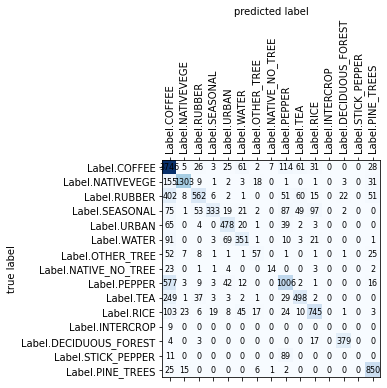

In [16]:
plot_confusion_matrix(conf_matrices[0], labels)

In [20]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.67048505 0.95387994 0.78272981 0.89276139 0.73200613 0.67891683
 0.54285714 0.63636364 0.69236063 0.7270073  0.79509072        nan
 0.92892157        nan 0.84409136]
Mean precision:  nan

Recalls:  [0.91165734 0.85330714 0.47627119 0.45060893 0.78104575 0.63818182
 0.36774194 0.29166667 0.60203471 0.60363636 0.74203187 0.
 0.94044665 0.         0.94549499]
Mean recall:  0.573608357039286

F-Score:  [0.77268977 0.90079502 0.59220232 0.59892086 0.75573123 0.6579194
 0.43846154 0.4        0.64404609 0.65960265 0.76764554        nan
 0.93464858        nan 0.89192025]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/src/statisticsUtils.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


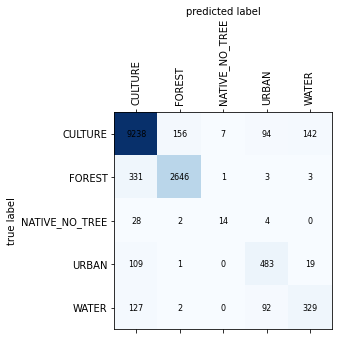

In [18]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [19]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93948947 0.94264339 0.63636364 0.71449704 0.6673428 ]
Mean precision:  0.7800672685426117

Recalls:  [0.95859707 0.88672922 0.29166667 0.78921569 0.59818182]
Mean recall:  0.7048780934842497

F-Score:  [0.9489471  0.91383181 0.4        0.75       0.63087248]
Mean f-score:  0.7287302778598027


## Same but with new categories and collection2

In [4]:
# Without :
# Label.INTERCROP,
# Label.STICK_FOR_PEPPER,   
# Label.PEPPER_AND_COFFEE,     
# Label.PEPPER_AND_OTHER
# Label.SPARE_TREE,     


labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [5]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [7]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [15]:
# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs) # the correct rescaling factor for surface reflectance dataset
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "january_to_april_2018_multi_output_focal_loss_collection2_new_categories"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 9, 9, 7)      0           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 9, 7)      28          rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 9, 9, 32)     2048        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [16]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.4535 - label_loss: 0.3396 - category_loss: 0.1139 - label_accuracy: 0.4070 - category_accuracy: 0.7236
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3253 - label_loss: 0.2490 - category_loss: 0.0763 - label_accuracy: 0.5389 - category_accuracy: 0.7896
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2822 - label_loss: 0.2184 - category_loss: 0.0638 - label_accuracy: 0.5767 - category_accuracy: 0.8179
Epoch 4/500
440/440 [==============================] - 2s 5ms/step - loss: 0.2621 - label_loss: 0.2038 - category_loss: 0.0583 - label_accuracy: 0.5963 - category_accuracy: 0.8301
Epoch 5/500
440/440 [==============================] - 2s 5ms/step - loss: 0.2453 - label_loss: 0.1904 - category_loss: 0.0548 - label_accuracy: 0.6177 - category_accuracy: 0.8423
Epoch 6/500
440/440 [==============================] - 2s 5ms/step - loss: 0.2262 - label_loss: 0.17

440/440 [==============================] - 2s 6ms/step - loss: 0.1047 - label_loss: 0.0812 - category_loss: 0.0234 - label_accuracy: 0.7854 - category_accuracy: 0.9136
Epoch 92/500
440/440 [==============================] - 2s 6ms/step - loss: 0.1030 - label_loss: 0.0799 - category_loss: 0.0231 - label_accuracy: 0.7853 - category_accuracy: 0.9140
Epoch 93/500
440/440 [==============================] - 2s 6ms/step - loss: 0.1027 - label_loss: 0.0793 - category_loss: 0.0234 - label_accuracy: 0.7869 - category_accuracy: 0.9144
Epoch 94/500
440/440 [==============================] - 3s 6ms/step - loss: 0.1037 - label_loss: 0.0804 - category_loss: 0.0233 - label_accuracy: 0.7854 - category_accuracy: 0.9107
Epoch 95/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0972 - label_loss: 0.0755 - category_loss: 0.0217 - label_accuracy: 0.7917 - category_accuracy: 0.9166
Epoch 96/500
440/440 [==============================] - 2s 5ms/step - loss: 0.1022 - label_loss: 0.0786 - ca

440/440 [==============================] - 2s 6ms/step - loss: 0.0871 - label_loss: 0.0675 - category_loss: 0.0196 - label_accuracy: 0.8081 - category_accuracy: 0.9243
Epoch 182/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0927 - label_loss: 0.0719 - category_loss: 0.0208 - label_accuracy: 0.8011 - category_accuracy: 0.9208
Epoch 183/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0891 - label_loss: 0.0694 - category_loss: 0.0197 - label_accuracy: 0.8044 - category_accuracy: 0.9249
Epoch 184/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0867 - label_loss: 0.0670 - category_loss: 0.0197 - label_accuracy: 0.8076 - category_accuracy: 0.9226
Epoch 185/500
440/440 [==============================] - 2s 6ms/step - loss: 0.0873 - label_loss: 0.0678 - category_loss: 0.0194 - label_accuracy: 0.8059 - category_accuracy: 0.9206
Epoch 186/500
440/440 [==============================] - 2s 6ms/step - loss: 0.0873 - label_loss: 0.0675

440/440 [==============================] - 3s 6ms/step - loss: 0.0814 - label_loss: 0.0634 - category_loss: 0.0180 - label_accuracy: 0.8137 - category_accuracy: 0.9288
Epoch 272/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0843 - label_loss: 0.0658 - category_loss: 0.0185 - label_accuracy: 0.8106 - category_accuracy: 0.9245
Epoch 273/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0848 - label_loss: 0.0656 - category_loss: 0.0192 - label_accuracy: 0.8110 - category_accuracy: 0.9235
Epoch 274/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0806 - label_loss: 0.0625 - category_loss: 0.0182 - label_accuracy: 0.8141 - category_accuracy: 0.9261
Epoch 275/500
440/440 [==============================] - 2s 6ms/step - loss: 0.0833 - label_loss: 0.0641 - category_loss: 0.0192 - label_accuracy: 0.8191 - category_accuracy: 0.9283
Epoch 276/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0820 - label_loss: 0.0634

440/440 [==============================] - 3s 6ms/step - loss: 0.0763 - label_loss: 0.0596 - category_loss: 0.0167 - label_accuracy: 0.8271 - category_accuracy: 0.9344
Epoch 362/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0814 - label_loss: 0.0630 - category_loss: 0.0184 - label_accuracy: 0.8221 - category_accuracy: 0.9301
Epoch 363/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0791 - label_loss: 0.0623 - category_loss: 0.0169 - label_accuracy: 0.8224 - category_accuracy: 0.9320
Epoch 364/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0804 - label_loss: 0.0623 - category_loss: 0.0181 - label_accuracy: 0.8255 - category_accuracy: 0.9293
Epoch 365/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0802 - label_loss: 0.0625 - category_loss: 0.0178 - label_accuracy: 0.8250 - category_accuracy: 0.9351
Epoch 366/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0788 - label_loss: 0.0611

440/440 [==============================] - 3s 6ms/step - loss: 0.0740 - label_loss: 0.0577 - category_loss: 0.0164 - label_accuracy: 0.8251 - category_accuracy: 0.9346
Epoch 452/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0744 - label_loss: 0.0577 - category_loss: 0.0167 - label_accuracy: 0.8322 - category_accuracy: 0.9346
Epoch 453/500
440/440 [==============================] - 3s 6ms/step - loss: 0.0714 - label_loss: 0.0555 - category_loss: 0.0159 - label_accuracy: 0.8315 - category_accuracy: 0.9360
Epoch 454/500
440/440 [==============================] - 2s 6ms/step - loss: 0.0769 - label_loss: 0.0591 - category_loss: 0.0178 - label_accuracy: 0.8310 - category_accuracy: 0.9349
Epoch 455/500
440/440 [==============================] - 2s 6ms/step - loss: 0.0715 - label_loss: 0.0553 - category_loss: 0.0162 - label_accuracy: 0.8387 - category_accuracy: 0.9385
Epoch 456/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0756 - label_loss: 0.0595

In [17]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [18]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.17562149465084076
accuracy:  0.14274093508720398


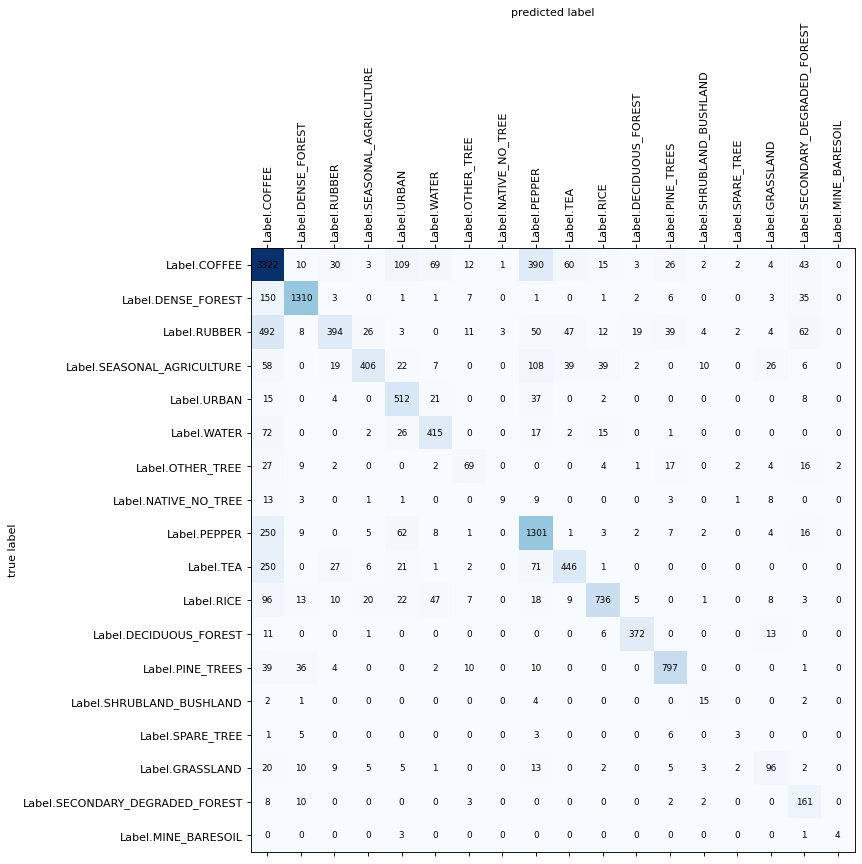

In [19]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [20]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.68835475 0.91994382 0.78486056 0.85473684 0.65057179 0.72299652
 0.56557377 0.69230769 0.64025591 0.7384106  0.88038278 0.91625616
 0.87678768 0.38461538 0.25       0.56470588 0.45224719 0.66666667]
Mean precision:  0.6805374429460889

Recalls:  [0.81004633 0.86184211 0.33503401 0.54716981 0.85475793 0.75454545
 0.44516129 0.1875     0.7785757  0.54060606 0.73969849 0.92307692
 0.8865406  0.625      0.16666667 0.55491329 0.8655914  0.5       ]
Mean recall:  0.6320403374667876

F-Score:  [0.74425899 0.88994565 0.46960667 0.66721446 0.73881674 0.73843416
 0.49819495 0.29508197 0.70267351 0.62421274 0.80393228 0.91965389
 0.88163717 0.47619048 0.2        0.55976676 0.59409594 0.57142857]
Mean f-score:  0.6319524960885192


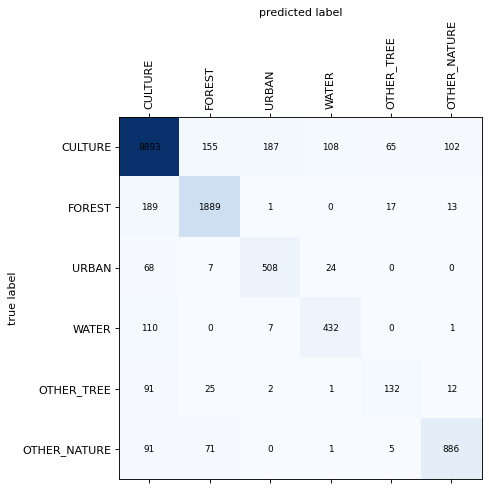

In [21]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [22]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.94185554 0.87983232 0.72056738 0.76325088 0.60273973 0.87376726]
Mean precision:  0.7970021844904599

Recalls:  [0.93512093 0.89568516 0.8369028  0.78545455 0.50190114 0.84060721]
Mean recall:  0.7992786302681533

F-Score:  [0.93847615 0.88768797 0.77439024 0.77419355 0.54771784 0.85686654]
Mean f-score:  0.7965553820883297


## Same but with an architecture without global average pooling

In [9]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "january_to_april_2018_multi_output_focal_loss_collection2_new_categories"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 16)     464         batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
440/440 [==============================] - 2s 4ms/step - loss: 0.4462 - label_loss: 0.3368 - category_loss: 0.1095 - label_accuracy: 0.4348 - category_accuracy: 0.7552
Epoch 2/500
440/440 [==============================] - 2s 4ms/step - loss: 0.3185 - label_loss: 0.2459 - category_loss: 0.0726 - label_accuracy: 0.5419 - category_accuracy: 0.8103
Epoch 3/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2789 - label_loss: 0.2160 - category_loss: 0.0629 - label_accuracy: 0.5830 - category_accuracy: 0.8299
Epoch 4/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2676 - label_loss: 0.2073 - category_loss: 0.0603 - label_accuracy: 0.5939 - category_accuracy: 0.8320
Epoch 5/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2485 - label_loss: 0.1933 - category_loss: 0.0552 - label_accuracy: 0.6130 - category_accuracy: 0.8430
Epoch 6/500
440/440 [==============================] - 2s 4ms/step - loss: 0.2393 - label_loss: 0.18

440/440 [==============================] - 2s 4ms/step - loss: 0.1159 - label_loss: 0.0907 - category_loss: 0.0252 - label_accuracy: 0.7674 - category_accuracy: 0.9095
Epoch 92/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1170 - label_loss: 0.0917 - category_loss: 0.0254 - label_accuracy: 0.7608 - category_accuracy: 0.9065
Epoch 93/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1163 - label_loss: 0.0911 - category_loss: 0.0252 - label_accuracy: 0.7648 - category_accuracy: 0.9065
Epoch 94/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1153 - label_loss: 0.0902 - category_loss: 0.0250 - label_accuracy: 0.7636 - category_accuracy: 0.9056
Epoch 95/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1135 - label_loss: 0.0891 - category_loss: 0.0244 - label_accuracy: 0.7678 - category_accuracy: 0.9097
Epoch 96/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1158 - label_loss: 0.0906 - ca

440/440 [==============================] - 2s 4ms/step - loss: 0.1010 - label_loss: 0.0787 - category_loss: 0.0223 - label_accuracy: 0.7869 - category_accuracy: 0.9158
Epoch 182/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0962 - label_loss: 0.0746 - category_loss: 0.0216 - label_accuracy: 0.7878 - category_accuracy: 0.9162
Epoch 183/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0976 - label_loss: 0.0759 - category_loss: 0.0216 - label_accuracy: 0.7882 - category_accuracy: 0.9160
Epoch 184/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0954 - label_loss: 0.0750 - category_loss: 0.0204 - label_accuracy: 0.7918 - category_accuracy: 0.9185
Epoch 185/500
440/440 [==============================] - 2s 4ms/step - loss: 0.1005 - label_loss: 0.0783 - category_loss: 0.0222 - label_accuracy: 0.7835 - category_accuracy: 0.9145
Epoch 186/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0980 - label_loss: 0.0768

440/440 [==============================] - 2s 4ms/step - loss: 0.0866 - label_loss: 0.0676 - category_loss: 0.0190 - label_accuracy: 0.7988 - category_accuracy: 0.9249
Epoch 272/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0891 - label_loss: 0.0701 - category_loss: 0.0190 - label_accuracy: 0.8019 - category_accuracy: 0.9225
Epoch 273/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0904 - label_loss: 0.0702 - category_loss: 0.0202 - label_accuracy: 0.8044 - category_accuracy: 0.9218
Epoch 274/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0874 - label_loss: 0.0693 - category_loss: 0.0182 - label_accuracy: 0.8018 - category_accuracy: 0.9239
Epoch 275/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0884 - label_loss: 0.0689 - category_loss: 0.0195 - label_accuracy: 0.7976 - category_accuracy: 0.9225
Epoch 276/500
440/440 [==============================] - 2s 4ms/step - loss: 0.0860 - label_loss: 0.0669

440/440 [==============================] - 2s 4ms/step - loss: 0.0858 - label_loss: 0.0665 - category_loss: 0.0193 - label_accuracy: 0.8075 - category_accuracy: 0.9229
Epoch 362/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0830 - label_loss: 0.0650 - category_loss: 0.0180 - label_accuracy: 0.8114 - category_accuracy: 0.9273
Epoch 363/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0821 - label_loss: 0.0644 - category_loss: 0.0177 - label_accuracy: 0.8087 - category_accuracy: 0.9266
Epoch 364/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0807 - label_loss: 0.0635 - category_loss: 0.0172 - label_accuracy: 0.8118 - category_accuracy: 0.9276
Epoch 365/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0831 - label_loss: 0.0653 - category_loss: 0.0179 - label_accuracy: 0.8044 - category_accuracy: 0.9268
Epoch 366/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0799 - label_loss: 0.0625

440/440 [==============================] - 2s 5ms/step - loss: 0.0798 - label_loss: 0.0620 - category_loss: 0.0178 - label_accuracy: 0.8151 - category_accuracy: 0.9282
Epoch 452/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0776 - label_loss: 0.0611 - category_loss: 0.0165 - label_accuracy: 0.8159 - category_accuracy: 0.9317
Epoch 453/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0791 - label_loss: 0.0609 - category_loss: 0.0182 - label_accuracy: 0.8151 - category_accuracy: 0.9291
Epoch 454/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0803 - label_loss: 0.0636 - category_loss: 0.0167 - label_accuracy: 0.8140 - category_accuracy: 0.9321
Epoch 455/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0805 - label_loss: 0.0632 - category_loss: 0.0174 - label_accuracy: 0.8149 - category_accuracy: 0.9317
Epoch 456/500
440/440 [==============================] - 2s 5ms/step - loss: 0.0765 - label_loss: 0.0598

In [11]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [12]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.214972585439682
accuracy:  0.17019133269786835


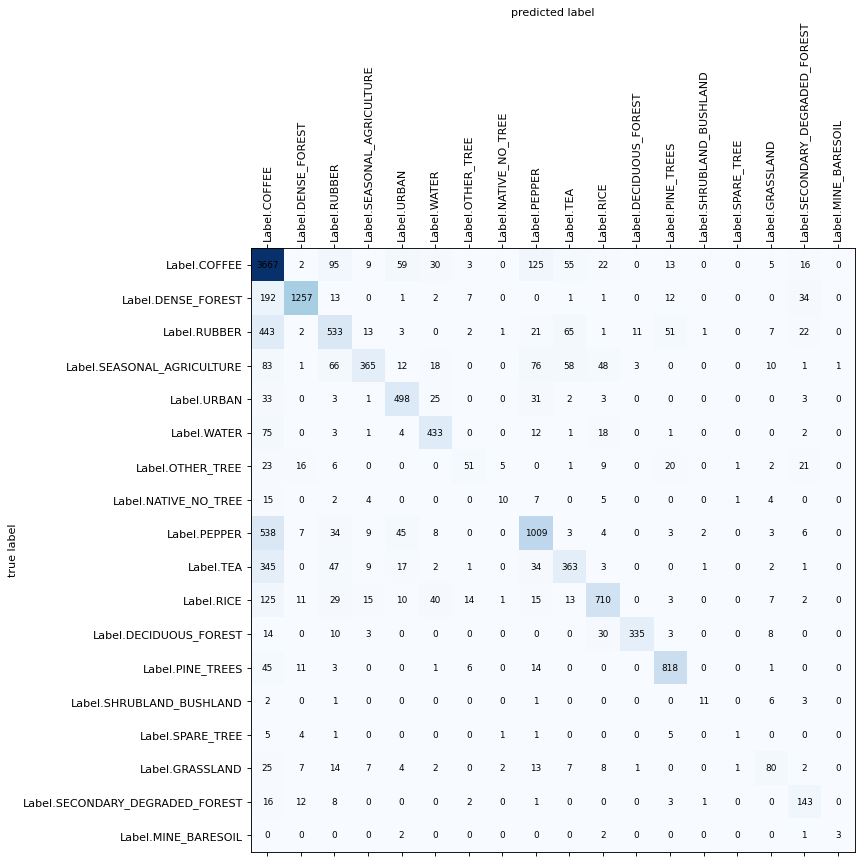

In [13]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.64948636 0.94511278 0.6140553  0.83715596 0.76030534 0.77183601
 0.59302326 0.5        0.74191176 0.63796134 0.82175926 0.95714286
 0.8776824  0.6875     0.25       0.59259259 0.55642023 0.75      ]
Mean precision:  0.6968858588640157

Recalls:  [0.89417215 0.82697368 0.45323129 0.49191375 0.83138564 0.78727273
 0.32903226 0.20833333 0.60383004 0.44       0.71356784 0.83126551
 0.90989989 0.45833333 0.05555556 0.46242775 0.7688172  0.375     ]
Mean recall:  0.5800562197384467

F-Score:  [0.75243665 0.88210526 0.52152642 0.6196944  0.79425837 0.77947795
 0.42323651 0.29411765 0.66578687 0.52080344 0.76385153 0.88977424
 0.89350082 0.55       0.09090909 0.51948052 0.64559819 0.5       ]
Mean f-score:  0.6170309952526412


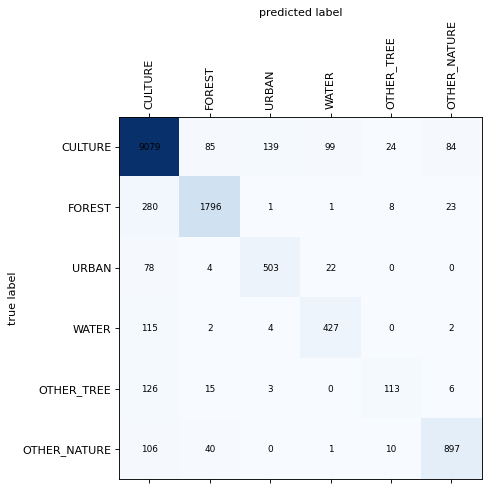

In [15]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.92794358 0.92481977 0.77384615 0.77636364 0.72903226 0.88636364]
Mean precision:  0.8363948399041193

Recalls:  [0.95467928 0.85158843 0.82866557 0.77636364 0.42965779 0.85104364]
Mean recall:  0.7819997263620371

F-Score:  [0.94112159 0.88669464 0.80031822 0.77636364 0.54066986 0.86834463]
Mean f-score:  0.8022520956006988


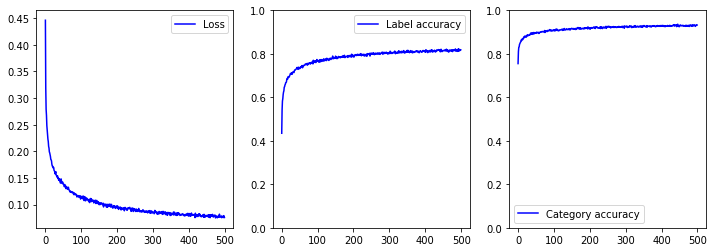

In [17]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()

## Same but with an architecture without global average pooling and on a whole year

In [5]:
# Without :
# Label.INTERCROP,
# Label.STICK_FOR_PEPPER,   
# Label.PEPPER_AND_COFFEE,     
# Label.PEPPER_AND_OTHER

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.SPARE_TREE,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [ ]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [ ]:
dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2019_whole_year_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [ ]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [ ]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(0.0000275, offset=0.2)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Conv2D(filters=16, kernel_size=(2, 2), padding="same")(layers)
layers = BatchNormalization()(layers)
layers = Activation(activations.relu)(layers)
layers = Flatten(name="last_pretrained_layer")(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.5, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

model_name = "whole_year_2018_multi_output_focal_loss_collection2_new_categories"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

In [ ]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

In [ ]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [ ]:
print("loss: ", loss)
print("accuracy: ", accuracy)

In [ ]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrices[0], labels)

In [ ]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

In [ ]:
pl.figure(figsize=(8, 6), dpi=80)

plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [ ]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

In [ ]:
figure, axis = pl.subplots(1, 3, figsize=(12,4))
axis[0].plot(history.history['loss'], label='Loss', color="blue")
axis[0].legend()
axis[1].plot(history.history['label_accuracy'], label='Label accuracy', color="blue")
axis[1].set_ylim([0,1])
axis[1].legend()
axis[2].plot(history.history['category_accuracy'], label='Category accuracy', color="blue")
axis[2].set_ylim([0,1])
axis[2].legend()